# <p style="text-align: center;">Интерпретация результатов A/B теста</p>

## Описание эксперимента

Перед вами таблица с результатами A/B-теста. В числовой колонке показаны значения выручки по каждому пользователю за период эксперимента.

## Описание колонок

value – значения метрики  
experimentVariant – Вариант теста (Control – контроль, Treatment – тест)  

## Задача  
Нужно понять, стали ли мы больше зарабатывать с пользователя или нет. Вы уже знаете о существовании t-теста, U-теста Mann-Whitney и бутстрапа. Открытый вопрос: какой инструмент использовать?

1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

2. Сравните результат между тестом и контролем по всем этим кейсам

3. Напишите выводы, которые можно сделать на основе анализа примененных критериев. Напишите, почему мы должны использовать тот или иной инструмент: каких предположений о случайной величине нужно придерживаться, какие условия необходимы и т.п.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm

In [87]:
url = 'https://disk.yandex.ru/d/FPMcY4_9kTUpNg'
root = 'https://getfile.dokpub.com/yandex/get/'
df = pd.read_csv(root + url, sep=';', index_col=0, decimal=',')
df

,value,experimentVariant
1,10.380495,Control
2,9.546867,Control
3,11.088215,Control
4,10.147274,Control
5,9.789808,Control
...,...,...
996,1000.000000,Treatment
997,1200.000000,Treatment
998,1500.000000,Treatment
999,2000.000000,Treatment


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   value              1000 non-null   float64
 1   experimentVariant  1000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 23.4+ KB


Делим данные контрольную и тестовую часть.

In [97]:
control = df[df['experimentVariant'] == 'Control'].value
test = df[df['experimentVariant'] == 'Treatment'].value

## 1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

Считаем t-критерий Стьюдента

In [90]:
stats.ttest_ind(control, test)

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

Считаем U-критерий Манна-Уитни

In [91]:
stats.mannwhitneyu(control, test)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

Создаём функцию для бутстрапа

In [92]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

Считаем бутстрап

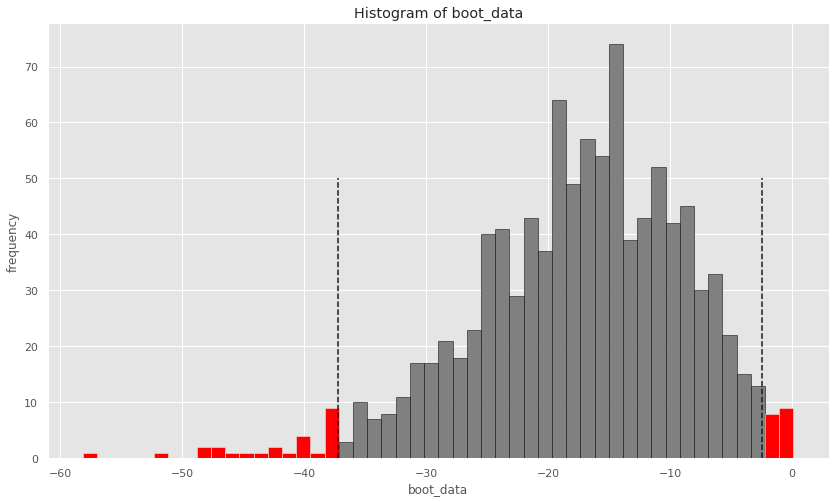

In [93]:
booted_data = get_bootstrap(control, test) # в результате хранится разница двух распределений, ДИ и pvalue

In [94]:
booted_data['p_value']

0.04507386242710057

## 2. Сравните результат между тестом и контролем по всем этим кейсам

У нас получились следующие p-value:  
 - t-критерий Стьюдента: 0.038
 - U-критерий Манна-Уитни: 0.859
 - бутстрап средних: 0.045

## 3. Напишите выводы, которые можно сделать на основе анализа примененных критериев. Напишите, почему мы должны использовать тот или иной инструмент: каких предположений о случайной величине нужно придерживаться, какие условия необходимы и т.п.

Результаты противоречивые. Уровень значимости равен 0.05, значит 2 инструмента (t-критерий Стьюдента и бутстрап средний) отклоняют нулевую гипотезу, а U-критерий Манна-Уитни принимает.

Вспомним, что в требования для применения t-критерия Стьюдента входят **нормальность распределения выборок** и **равная дисперсия**.  
Поэтому протестируем наши выборки на нормальность, а так же посчитаем их дисперсию.

In [105]:
stats.normaltest(control)

NormaltestResult(statistic=2.9434587202565154, pvalue=0.22952820483957936)

In [106]:
np.var(control)

0.9572617077286163

In [107]:
stats.normaltest(test)

NormaltestResult(statistic=929.5157667884811, pvalue=1.439513760946726e-202)

In [108]:
np.var(test)

34733.91141330792

Как видно, контрольная выборка имеет нормальное распределение, а тестовая - отличное от нормального. Также у выборок сильно различается дисперсия. Можно предположить, что тестовая выборка имеет выбросы, которые и являются причиной различий выборок.

Значит t-критерий Стьюдента нам не подходит. Бутстрап средних тоже не подходит, так как оба инструмента являются параметрическими и если в выборке есть аномалии, то они могут сильно повлиять на результаты.

Поэтому в данном случае лучше использовать непараметрические критерии и U-критерий Манна-Уитни нам отлично подходит. А ещё может подойти бутстрап через медианы, так как выбирая медиану вместо среднего мы как раз убираем парамеритку. Для интереса посчитаем бутстрап через медианы:

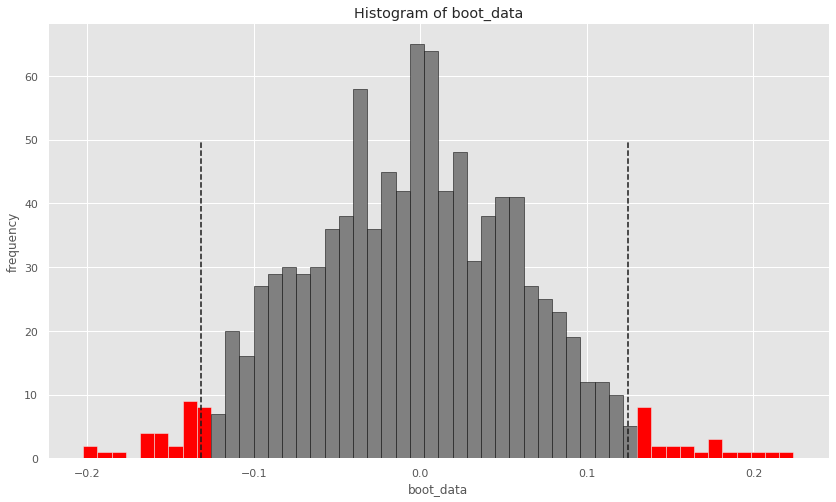

In [110]:
boot_data2 = get_bootstrap(control, test, statistic=np.median)

In [112]:
boot_data2['p_value']

0.9449749169163307

Результат такой же, как с U-критерием Манна-Уитни, статистически значимых отличий между выборками нет.